# **ANALISIS SENTIMEN MENGGUNAKAN SGD DAN LINEAR SVC TERHADAP REVIEWS PLATFORM AMAZON**

In [109]:
pip install scikit-plot

## **Load Package dan Modul**

In [110]:
from wordcloud import WordCloud, STOPWORDS # STOPWORDS digunakan menghapus kata-kata umum yang tidak relevan dalam teks

from scipy.sparse import hstack # untuk menggabungkan matriks sparse secara horizontal

from sklearn.svm import LinearSVC # model Linear Support Vector Classifier (LinearSVC) untuk training
from sklearn.linear_model import SGDClassifier # model Stochastic Gradient Descent Classifier (SGDClassifier) untuk training

from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer # untuk melakukan ekstraksi teks menggunakan metode TF-IDF
from sklearn.model_selection import train_test_split # untuk membagi data menjadi set traning dan set testing

import scikitplot as skplt
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Load Data**

In [111]:
# https://github.com/jirenmaa/test_sentiment_analysis_dataset
urls = [
    'https://raw.githubusercontent.com/jirenmaa/test_sentiment_analysis_dataset/main/amazon_review_furniture_big.csv',
    'https://raw.githubusercontent.com/jirenmaa/test_sentiment_analysis_dataset/main/amazon_review_music-instrument_big.csv'
]

In [112]:
# membaca dataset dari url dan menyimpannya dalam list
dfs = [pd.read_csv(url) for url in urls]

# menggabungkan semua dataset yang tersimpan dalam list
# ignore_index=True digunakan untuk mengatur ulang indeks DataFrame hasil penggabungan agar mulai dari 1 lagi
df = pd.concat(dfs, ignore_index=True)

In [113]:
print(df.shape)

df.head()

(120000, 15)


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,24509695,R3VR960AHLFKDV,B004HB5E0E,488241329,Shoal Creek Computer Desk,Furniture,4,0,0,N,Y,... desk is very study and it i has a beautifu...,This desk is very study and it i has a beauti...,8/31/2015
1,US,34731776,R16LGVMFKIUT0G,B0042TNMMS,205864445,Dorel Home Products Delaney Large Rectangular ...,Furniture,5,0,0,N,Y,Five Stars,Great item,8/31/2015
2,US,1272331,R1AIMEEPYHMOE4,B0030MPBZ4,124663823,Bathroom Vanity Table Jewelry Makeup Desk Benc...,Furniture,5,1,1,N,Y,Five Stars,"Perfect fit for my bedroom, been wanting one s...",8/31/2015
3,US,45284262,R1892CCSZWZ9SR,B005G02ESA,382367578,Sleep Master Ultima Comfort Memory Foam 6 Inch...,Furniture,3,0,0,N,Y,Good enough,"We use this on a trundle bed. So, it does not...",8/31/2015
4,US,30003523,R285P679YWVKD1,B005JS8AUA,309497463,"1 1/4"" GashGuards: Deluxe Rubberized Plastic B...",Furniture,3,0,0,N,N,Gash Gards for daybed,The product is fine...just seemed like it took...,8/31/2015


### **Data Cleaning**

In [114]:
'''
Memilih subset kolom yang akan digunakan untuk training dari DataFrame
dan menyimpannya kembali ke dalam DataFrame yang sama.
'''
df = df[['review_id', 'product_title', 'star_rating', 'verified_purchase', 'review_headline', 'review_body']]

In [115]:
df.isnull().sum() # menampilkan jumlah data per row yang nilai NaN atau None

review_id             0
product_title         0
star_rating           0
verified_purchase     0
review_headline       0
review_body          42
dtype: int64

In [116]:
df = df.dropna() # menghapus data yang NaN atau None dari dataframe

<Axes: >

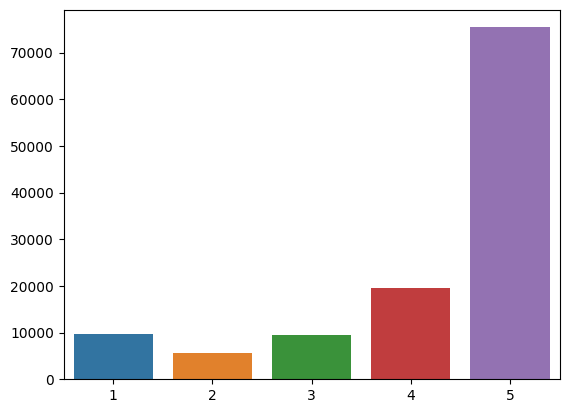

In [117]:
# menampilkan grafik dari banyaknya rating dari jumlah dataset
data = df['star_rating'].value_counts()

sns.barplot(x=data.index, y=data.values)

In [118]:
# menyimpan banyaknya data dari pembelian terverifikasi dalam dataset
data_purchase_dirty = df['verified_purchase'].value_counts()

# menghapus review dari dataset jika pembelian terverifikasi bukan True
df = df[df['verified_purchase'] == 'Y']

# data dari pembelian terverifikasi dalam dataset yang sudah dibersihkan
# dari data review yang belum membeli barang tersebut
data_purchase_cleaned = df['verified_purchase'].value_counts()

In [119]:
print(data_purchase_dirty)

Y    112305
N      7653
Name: verified_purchase, dtype: int64


In [120]:
print(data_purchase_cleaned)

Y    112305
Name: verified_purchase, dtype: int64


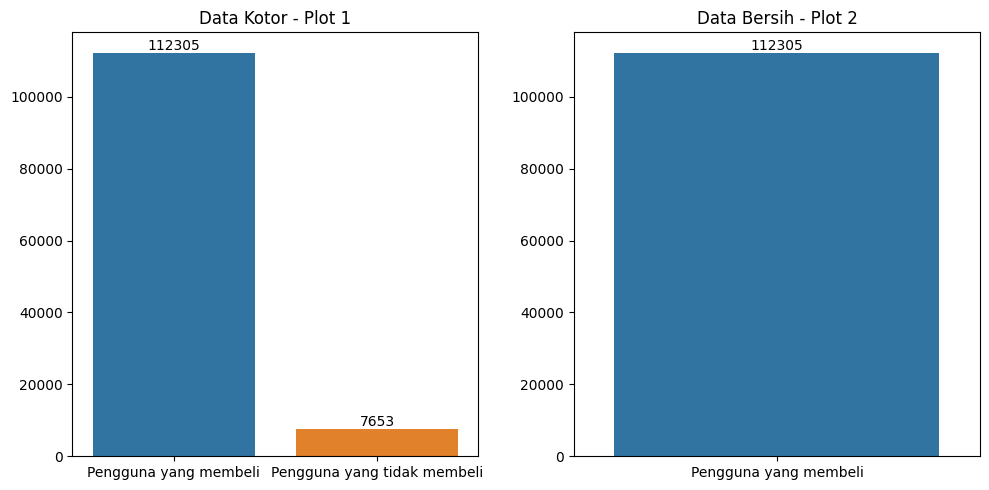

In [121]:
# membuat dua sumbu (axes)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# plot pertama
sns.barplot(x=data_purchase_dirty.index, y=data_purchase_dirty.values, ax=axes[0])
axes[0].set_title('Data Kotor - Plot 1')
axes[0].set_xticklabels(['Pengguna yang membeli', 'Pengguna yang tidak membeli'])

# menampilkan jumlah angka untuk data ke diagram batang Plot 1
for i, count in enumerate(data_purchase_dirty.values):
    axes[0].text(i, count, str(count), ha='center', va='bottom')

# plot kedua
sns.barplot(x=data_purchase_cleaned.index, y=data_purchase_cleaned.values, ax=axes[1])
axes[1].set_title('Data Bersih - Plot 2')
axes[1].set_xticklabels(['Pengguna yang membeli'])

# menampilkan jumlah angka untuk data ke diagram batang Plot 2
for i, count in enumerate(data_purchase_cleaned.values):
    axes[1].text(i, count, str(count), ha='center', va='bottom')

# menyesuaikan layout plot agar tidak overlapping
plt.tight_layout()

plt.show()

## **Word Cloud**

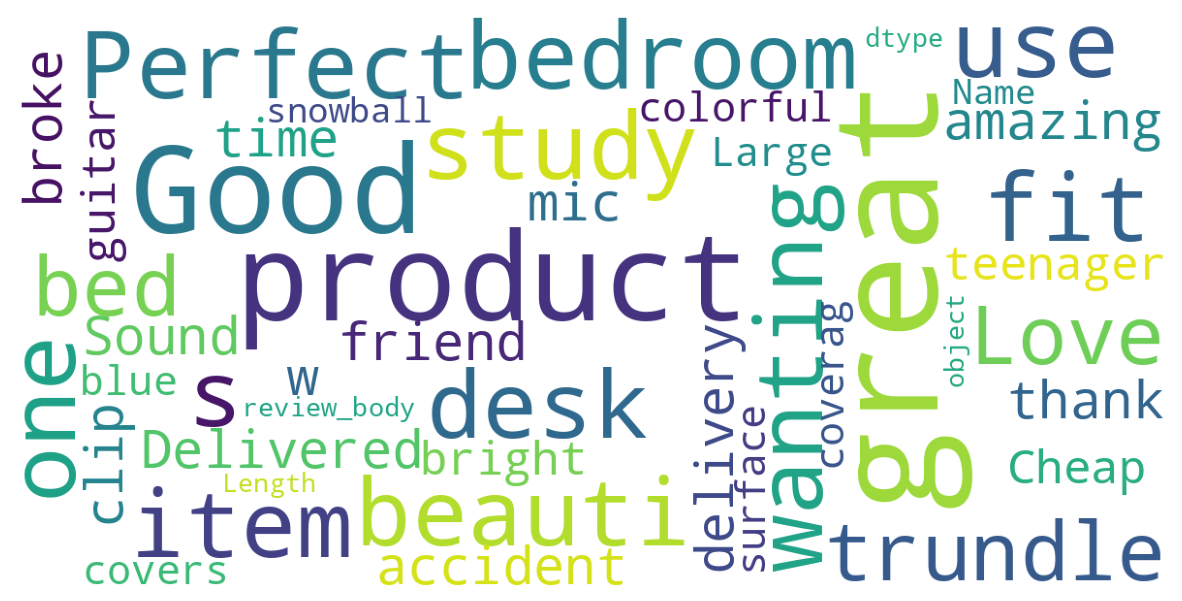

In [122]:
stopwords = set(STOPWORDS)

big_texts = str(df['review_body'])

# membuat objek WordCloud untuk ditampilkan kata-kata yang sering muncul
wordcloud = WordCloud(
    background_color='white',
    stopwords=stopwords,
    max_words=500,
    max_font_size=50,
    scale=3
).generate(big_texts)

# membuat plot untuk word cloud
fig = plt.figure(1, figsize=(15, 15))
plt.axis('off')

plt.imshow(wordcloud) # menampilkan gambar wordcloud

plt.show()

## **Model Setup Transformation**

In [89]:
'''
Package Python yang berguna untuk menyimpan dan memuat objek Python dengan efisien.
dirancang untuk bekerja dengan objek besar seperti array NumPy yang seringkali
digunakan dalam konteks pengolahan data dan machine learning.
'''
import joblib

In [123]:
based_data = df['product_title'] + ' ' + df['review_headline'] + ' ' +  df['review_body'] # digunakan untuk fitur input dan y_target
train_data = df['product_title'] + ' ' + df['review_headline'] + ' ' +  df['review_body']

# mengganti nilai peringkat bintang dengan label sentimen yang sesuai
y_target = df['star_rating'].map({ # 1, 2, 3, 4, 5
    1: 'Unhappy',
    2: 'Unhappy',
    3: 'Ok',
    4: 'Somewhat Happy',
    5: 'Happy'
})

In [124]:
# digunakan untuk mengekstrak fitur teks
vectorize_word = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',      # menghapus karakter unicode
    analyzer='word',              # analisis teks berdasarkan kata-kata
    token_pattern=r'\w{1,}',
    stop_words='english',         # menggunakan daftar stopwords bahasa Inggris
    ngram_range=(1, 1),           # menggunakan unigram (satu kata) sebagai fitur; https://www.mathworks.com/discovery/ngram.html
    max_features=100000           # Jumlah fitur maksimum (ada korelasi dengan ngram_range)
)

# melatih TfidfVectorizer
vectorize_word.fit(based_data)

# mengubah data pelatihan menjadi fitur teks matrix menggunakan .transform
train_features_word = vectorize_word.transform(train_data)

In [19]:
# digunakan untuk mengekstrak fitur teks
vectorize_char = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',      # Menghapus karakter unicode
    analyzer='char',              # Menganalisis teks berdasarkan karakter
    ngram_range=(2, 6),           # Menggunakan n-gram dari panjang 2 hingga 6 karakter
    max_features=100000           # Jumlah fitur maksimum
)

# melatih TfidfVectorizer
vectorize_char.fit(based_data)

# mengubah data pelatihan menjadi fitur teks matrix menggunakan .transform
train_features_char = vectorize_char.transform(train_data)

In [125]:
# menggabungkan fitur teks karakter dengan fitur teks kata menggunakan hstack dari package scipy
train_features = hstack([train_features_char, train_features_word])

In [126]:
# memisahkan dataset menjadi set-training dan set-testing
X_train, X_test, y_train, y_test = (
    train_test_split(
        train_features,      # Fitur teks yang akan dibagi
        y_target,            # Target atau label yang sesuai dengan fitur
        test_size=0.3,       # set-testing (30%) sisanya set-training (70%)
        random_state=101,    # seed untuk re-produktibilitas hasil
        shuffle=True         # acak dataset sebelum dilakukan pemisahan
    )
)

## **Modelling**

### **SVC Model**

In [127]:
'''
Membuat model SVM linier (Linear Support Vector Classification) dengan menggunakan LinearSVC

class_weight='balanced': memberi bobot yang lebih tinggi pada kelas yang kurang umum,
                         sehingga model lebih memperhatikan kelas minoritas
'''
lsvm = LinearSVC(class_weight='balanced')

# melatih model pada set pelatihan
l = lsvm.fit(X_train, y_train)

# menyimpan model dari LinearSVC yang sudah di training
joblib.dump(lsvm, 'linear_svc_model.joblib')

['linear_svc_model.joblib']

#### **Accuracy Test using Training Dataset**

In [128]:
pred_train = l.predict(X_train)

In [129]:
print("Accuracy Train: {}".format(
    accuracy_score(y_train, pred_train))
)

print(classification_report(y_train, pred_train))

Accuracy Train: 0.9832470456540267
                precision    recall  f1-score   support

         Happy       0.99      0.98      0.99     49612
            Ok       0.98      1.00      0.99      6311
Somewhat Happy       0.95      0.96      0.96     12870
       Unhappy       0.99      1.00      1.00      9820

      accuracy                           0.98     78613
     macro avg       0.98      0.99      0.98     78613
  weighted avg       0.98      0.98      0.98     78613



#### **Accuracy Test using Test Dataset**

In [130]:
pred_test = l.predict(X_test)

In [131]:
print("Accuracy Test : {}".format(
    accuracy_score(y_test, pred_test))
)

print(classification_report(y_test, pred_test))

Accuracy Test : 0.8174937670663659
                precision    recall  f1-score   support

         Happy       0.91      0.91      0.91     21143
            Ok       0.53      0.52      0.53      2653
Somewhat Happy       0.61      0.59      0.60      5548
       Unhappy       0.81      0.82      0.81      4348

      accuracy                           0.82     33692
     macro avg       0.71      0.71      0.71     33692
  weighted avg       0.82      0.82      0.82     33692



#### **Confusion Matrix SVC Model**

Mengevaluasi performa model klasifikasi dengan `membandingkan` prediksi model dengan `nilai sebenarnya` dari `data pengujian`

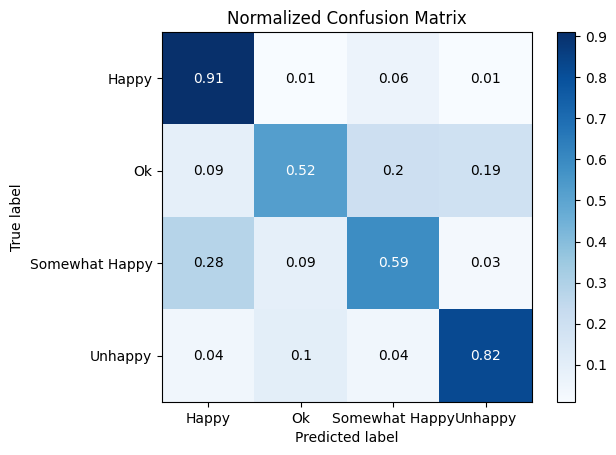

In [132]:
skplt.metrics.plot_confusion_matrix(y_test, pred_test, normalize=True)

plt.show()

### **SGDClassifier Model**

In [133]:
'''
SVM dengan optimasi menggunakan metode Stochastic Gradient Descent (SGD)

class_weight='balanced': memberi bobot yang lebih tinggi pada kelas yang kurang umum,
                         sehingga model lebih memperhatikan kelas minoritas
n_jobs=-1    : mengoptimalkan kinerja dengan menggunakan semua CPU yang tersedia (paralel)
max_iter=300 : jumlah iterasi maksimum ketika melatih model
'''
svm = SGDClassifier(class_weight='balanced', n_jobs=-1, max_iter=300)

# X_train : matriks fitur hasil ekstraksi fitur teks dari set-training
# y_train : array target yang berisi label sentimen untuk setiap sampel dalam set-training
svm.fit(X_train, y_train)

# menyimpan model dari SGDC yang sudah di training
joblib.dump(svm, 'sgd_classifier_model.joblib')

['sgd_classifier_model.joblib']

#### **Accuracy Test using Training Dataset**

In [134]:
pred_train_sgd = svm.predict(X_train)

In [135]:
print("Accuracy Train: {}".format(
    accuracy_score(y_train, pred_train_sgd))
)

print(classification_report(y_train, pred_train_sgd))

Accuracy Train: 0.8741047918283236
                precision    recall  f1-score   support

         Happy       0.92      0.95      0.94     49612
            Ok       0.68      0.77      0.72      6311
Somewhat Happy       0.86      0.58      0.69     12870
       Unhappy       0.80      0.94      0.86      9820

      accuracy                           0.87     78613
     macro avg       0.81      0.81      0.80     78613
  weighted avg       0.88      0.87      0.87     78613



#### **Accuracy Test using Test Dataset**

In [136]:
pred_test_sgd = svm.predict(X_test)

In [137]:
print("Accuracy Test: {}".format(
    accuracy_score(y_test, pred_test_sgd))
)

print(classification_report(y_test, pred_test_sgd))

Accuracy Test: 0.8294550635165618
                precision    recall  f1-score   support

         Happy       0.90      0.94      0.92     21143
            Ok       0.51      0.58      0.54      2653
Somewhat Happy       0.78      0.49      0.60      5548
       Unhappy       0.74      0.89      0.81      4348

      accuracy                           0.83     33692
     macro avg       0.73      0.72      0.72     33692
  weighted avg       0.83      0.83      0.82     33692



#### **Confusion Matrix SGDClassifier Model**

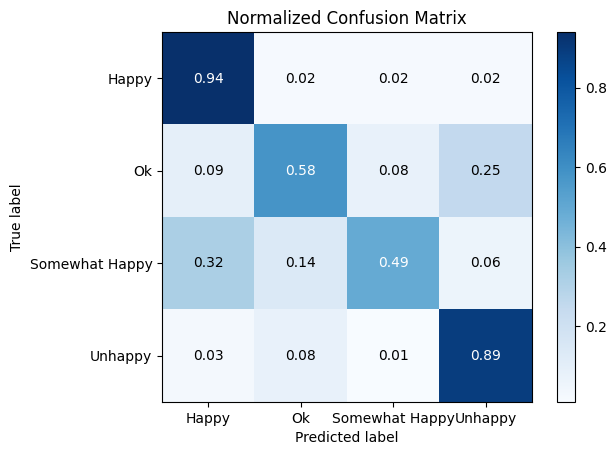

In [138]:
skplt.metrics.plot_confusion_matrix(y_test, pred_test_sgd, normalize=True)

plt.show()

## Model Testing With New Input

In [139]:
# Load the models
loaded_lsvm = joblib.load('linear_svc_model.joblib')
loaded_svm = joblib.load('sgd_classifier_model.joblib')

In [140]:
# unhappy
long_rev_1 = "Well, I like the one that works... This set of folding trays is just what I needed. My mother is very sick & I needed a portable table to serve her \
meals at her comfortable chair or a place to set a drink & meds on days when she just wanted to lie on the sofa. The shipment arrived on time, but when \
I opened the box, only 1 of the 2 trays was functional. The second tray did not have the 'stop' & the guiding metal bar on the bottom that allowed the tray \
to stay open & in-place. In short, it was not completely assembled & the missing parts were not in the box. Between chemo & doctor's visits & daily life responsibilities, \
I just don't have the time or energy to return this dang thing, besides I need the one that works... so you'll just have to settle for a poor rating."

# ok
long_rev_2 = "Upon receiving this product, my initial impression was mixed. The packaging seemed appealing, and the product design was interesting. \
However, as I started using it, I couldn't help but feel underwhelmed. The functionality is there, but somehow it lacks the wow factor. \
On the bright side, it did exceed my expectations in certain aspects. Overall, it's a decent product, but I can't say it left a lasting positive impression on me."

# somewhat happy
long_rev_3 = "At first glance, I was a bit underwhelmed by this product. The packaging seemed generic, and initial usage revealed some minor flaws in the design. \
I encountered a few hiccups during operation, which left me slightly frustrated. However, as I continued to use it, I discovered its hidden strengths. \
The functionality proved to be more robust than I initially thought, and it eventually won me over. Despite the rocky start, the product redeemed itself. \
In the end, I found its very positive aspects outweighing the initial drawbacks, making it a surprisingly satisfactory purchase, great stuff certainly \
going to buy it again."

# somewhat happy
long_rev_4 = "From the sleek packaging to the innovative design, this product initially impressed me. However, as I delved deeper, \
I started noticing a few drawbacks. The functionality, although generally good, had a few quirks that became more apparent over time. \
Despite these minor issues, the overall experience remained positive, making it worthwhile addition to my collection."

# unhappy
long_rev_5 = "good stuff, i like it, will not buy the second time."

new_text = [
    long_rev_1,
    long_rev_2,
    long_rev_3,
    long_rev_4,
    long_rev_5,

    "Not only did the design not match the photo, but the center image was well off-center and looked pretty awful.",   # unhappy
    "It's not that bad, but not good either. Still using it tho.",                                                      # ok
    "Haiyaa, uncle gonna show this to my son!",                                                                         # happy
    ":(",                                                                                                               # unhappy
    "This food should not be sold on this platform because it belongs in the finest restaurant.",                       # positive sarcasm - happy
    "😊",                                                                                                              # happy
    "i liked it, i was good at it. But you know it always didnt go as i planned, and i was so sad about what happend.", # ok atau unhappy
]

# fitur transformasi untuk texts baru
new_text_features_word = vectorize_word.transform(new_text)
new_text_features_char = vectorize_char.transform(new_text)

# menggabungkan dua matriks secara horizontal (menambahkan kolom)
# jadi setiap sampel dalam new_text_features memiliki representasi gabungan dari fitur kata dan fitur karakter
new_text_features = hstack([new_text_features_char, new_text_features_word])

In [141]:
# prediksi dengan LinearSVC model
prediction_lsvm = loaded_lsvm.predict(new_text_features)

print("LinearSVC Prediction\n")

for index, review in enumerate(prediction_lsvm):
    print(f"Review-{index + 1}\t: {review}")

LinearSVC Prediction

Review-1	: Unhappy
Review-2	: Ok
Review-3	: Somewhat Happy
Review-4	: Somewhat Happy
Review-5	: Somewhat Happy
Review-6	: Unhappy
Review-7	: Ok
Review-8	: Happy
Review-9	: Unhappy
Review-10	: Unhappy
Review-11	: Happy
Review-12	: Somewhat Happy


In [142]:
# prediksi dengan SGD Classifier model
prediction_svm1 = loaded_svm.predict(new_text_features)

print("SGD Classifier Prediction\n")

for index, review in enumerate(prediction_svm1):
    print(f"Review-{index + 1}\t: {review}")

SGD Classifier Prediction

Review-1	: Unhappy
Review-2	: Ok
Review-3	: Somewhat Happy
Review-4	: Somewhat Happy
Review-5	: Unhappy
Review-6	: Unhappy
Review-7	: Ok
Review-8	: Happy
Review-9	: Unhappy
Review-10	: Unhappy
Review-11	: Happy
Review-12	: Ok
